# **Improving Model performance on EMNIST**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**
* **EMINST Dataset**
    * Dataset containing (A-Z, a-z, 0-9) handwritten character images of size (28,28) grayscale
    * Total 814255 characters

In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import summary libraries for model information
from torchsummary import summary

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# extra imports
import copy

In [2]:
# Import and inspect the data
# cdata=tv.datasets.EMNIST(root='emnist',split='letters')
cdata=tv.datasets.EMNIST(root='emnist',split='letters',download=True)


In [3]:
#inspect the data

# the categories (but how many letters?)

print(cdata.classes)
print(str(len(cdata.classes))+'classes')

print("\nData Size:")
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images=cdata.data.view([124800,1,28,28]).float()
print('\nTensor Data: ')
print(images.shape)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27classes

Data Size:
torch.Size([124800, 28, 28])

Tensor Data: 
torch.Size([124800, 1, 28, 28])


In [4]:
# brief aside: class 'N/A' doesn't exist in the data
print(tr.sum(cdata.targets==0))

# however, it causes problems in one-hot encoding...
tr.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [5]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [6]:
# so therefore we'll eliminate 'N/A' and subtract 1 from the original labels

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels=copy.deepcopy(cdata.targets)-1
print(labels.shape)

print(tr.sum(labels==0))
print(tr.unique(labels))


torch.Size([124800])
tensor(4800)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])


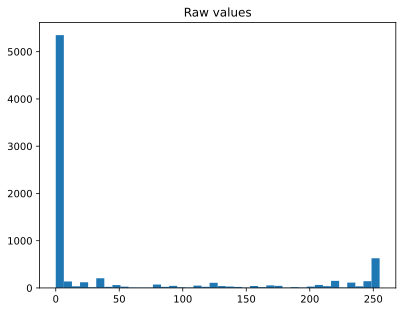

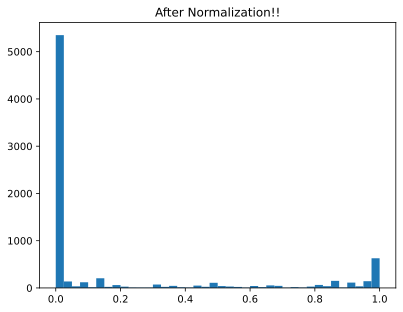

In [7]:
# next issue: do we need to normalize the images?
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Raw values')
plt.show()

# yarp.{Means YES!}
images/=tr.max(images)
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('After Normalization!!')
plt.show()

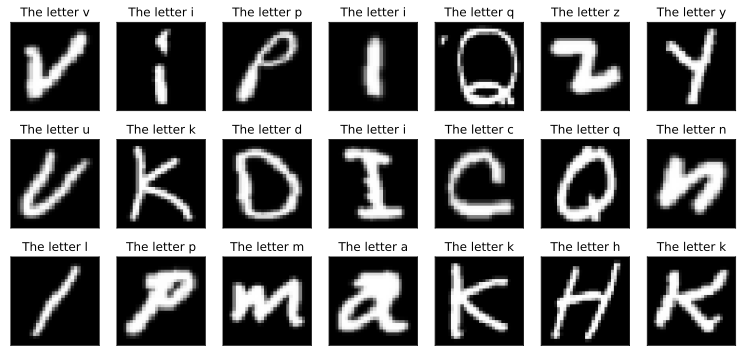

In [8]:
# visualization of some images
fig,axs=plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic=np.random.randint(images.shape[0])

  # extract the image and its target letter
  I=np.squeeze(images[whichpic,:,:])
  letter=letterCategories[labels[whichpic]]

  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title(f'The letter {letter}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()


In [9]:
# Create train/test groups using Dataloader

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(images,labels,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [10]:
# check size (should be images x channels x width x height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


In [13]:
def outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,outChannels):
    Nh=int(np.floor((imgSize[0]+2*paddingSize[0]-kernelSize[0])/strideSize[0]))+1
    Nw=int(np.floor((imgSize[1]+2*paddingSize[1]-kernelSize[1])/strideSize[1]))+1
    return outChannels,(Nh,Nw),(int(Nh//poolSize[0]),int(Nw//poolSize[1]))

def fcInput(imgSize,inChannels):
    return int(imgSize[0]*imgSize[1]*inChannels)

In [14]:
# creating a class for the model

convOutChannels=[64,128,256]
imgSize=(28,28)
kernelSize=(3,3)
strideSize=(1,1)
paddingSize=(1,1)
poolSize=(2,2)
fc_nodes=(256,64)
out_nodes=26

def createNet(printtoggle=False):
    class mnistNet(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()

            ### convolution layers

            # first convolution layer
            # conv 1
            self.conv1=nn.Conv2d(1,convOutChannels[0],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.bnorm1=nn.BatchNorm2d(convOutChannels[0]) # input the number of channels in this layers
            self.outcp1=outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,convOutChannels[0])

            # second convolutional layer
            self.conv2=nn.Conv2d(convOutChannels[0],convOutChannels[1],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.bnorm2=nn.BatchNorm2d(convOutChannels[1]) # input the number of channels in this layers
            self.outcp2=outConvPoolSize(self.outcp1[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[1])

            # third convolutional layer
            self.conv3=nn.Conv2d(convOutChannels[1],convOutChannels[2],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.bnorm3=nn.BatchNorm2d(convOutChannels[2]) # input the number of channels in this layers
            self.outcp3=outConvPoolSize(self.outcp2[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[2])

            ### linear decision layer 

            # fully-connected layer
            self.fci=fcInput(self.outcp3[2],self.outcp3[0])
            self.fc1=nn.Linear(self.fci,fc_nodes[0])
            self.fc2=nn.Linear(fc_nodes[0],fc_nodes[1])


            # output layer
            self.out=nn.Linear(fc_nodes[1],out_nodes)

            # toggle for printing out tensor sizes during forward prop
            self.print=printtoggle

        # forward propogation
        def forward(self,x):
            print(f'Input: {x.shape}') if self.print else None

            ### convolution -> maxpool -> relu (1)
            x = F.leaky_relu(self.bnorm1(F.max_pool2d(self.conv1(x),2)))
            print(f'Layer conv1/pool1: {x.shape}') if self.print else None
            x=F.dropout(x,p=0.25,training=self.training)

            ### convolution -> maxpool -> relu (2)
            x = F.leaky_relu(self.bnorm2(F.max_pool2d(self.conv2(x),2)))
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None
            x=F.dropout(x,p=0.25,training=self.training)

            ### convolution -> maxpool -> relu (3)
            x = F.leaky_relu(self.bnorm3(F.max_pool2d(self.conv3(x),2)))
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None
            x=F.dropout(x,p=0.25,training=self.training)

            # reshape for linear layer
            ### x.shape.numel() -->  gives total number of elements in the array/tuple
            nUnits=x.shape.numel()/x.shape[0]
            ### vectorizing
            x=x.view(-1,int(nUnits))
            print(f'Vectorize: {x.shape}') if self.print else None
            
            # linear layers
            x=F.leaky_relu(self.fc1(x))
            print(f'Layer fc1: {x.shape}') if self.print else None
            x=F.dropout(x,p=0.5,training=self.training)

            x=F.leaky_relu(self.fc2(x))
            print(f'Layer fc2: {x.shape}') if self.print else None
            x=F.dropout(x,p=0.5,training=self.training)

            x=self.out(x)
            print(f'Output: {x.shape}') if self.print else None

            return x
    
    # create the model instance
    net=mnistNet(printtoggle)

    # loss function
    lossfun=nn.CrossEntropyLoss()

    # optimizer
    optimizer=tr.optim.Adam(net.parameters(),lr=0.001)
    
    return net,lossfun,optimizer

In [15]:
# test the model with one batch
net,lossfun,optimizer = createNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

print('\nLabel size:')
print(y.shape)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,tr.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 64, 14, 14])
Layer conv2/pool2: torch.Size([32, 128, 7, 7])
Layer conv2/pool2: torch.Size([32, 256, 3, 3])
Vectorize: torch.Size([32, 2304])
Layer fc1: torch.Size([32, 256])
Layer fc2: torch.Size([32, 64])
Output: torch.Size([32, 26])

Label size:
torch.Size([32])

Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.3244, grad_fn=<NllLossBackward0>)


In [16]:
# setting up gpu
# use GPU if available
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
# count the total number of parameters in the model
net.to(device)
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 64, 14, 14])
Layer conv2/pool2: torch.Size([2, 128, 7, 7])
Layer conv2/pool2: torch.Size([2, 256, 3, 3])
Vectorize: torch.Size([2, 2304])
Layer fc1: torch.Size([2, 256])
Layer fc2: torch.Size([2, 64])
Output: torch.Size([2, 26])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 14, 14]             128
            Conv2d-3          [-1, 128, 14, 14]          73,856
       BatchNorm2d-4            [-1, 128, 7, 7]             256
            Conv2d-5            [-1, 256, 7, 7]         295,168
       BatchNorm2d-6            [-1, 256, 3, 3]             512
            Linear-7                  [-1, 256]         590,080
            Linear-8                   [-1, 64]          16,448
            Linear-9                   [-1, 26]           1,69

In [18]:
# Create a function that trains the model

def trainModel(n_epochs=10):
    # create a new model
    net,lossfun,optimizer=createNet()

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    testLoss = tr.zeros(n_epochs)
    trainErr = tr.zeros(n_epochs)
    testErr = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]
        batchErr=[]

        for X,y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat=net(X)
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            batchErr.append(tr.mean((tr.argmax(yHat,axis=1)!=y).float()).item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)
        trainErr[epochi]=100*np.mean(batchErr)

        # test accuracy
        X,y=next(iter(test_loader))
        # push data to GPU
        X = X.to(device)
        y = y.to(device)
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)
            loss=lossfun(yHat,y)

        # compare the following really long lines of code to the training accuracy lines
        testLoss[epochi]=loss.item()
        testErr[epochi]=100*tr.mean((tr.argmax(yHat,axis=1)!=y).float()).item()

        print(f"{epochi+1}/{n_epochs} complete!")
    # end of epochs

    # function output
    return trainLoss,testLoss,trainErr,testErr,net

In [19]:
# Run the model and show the results!
# GPU ~ 1min; CPU~20.478 mins (Ryzen 7 5700u)
trainLoss,testLoss,trainErr,testErr,net=trainModel()

1/10 complete!
2/10 complete!
3/10 complete!
4/10 complete!
5/10 complete!
6/10 complete!
7/10 complete!
8/10 complete!
9/10 complete!
10/10 complete!


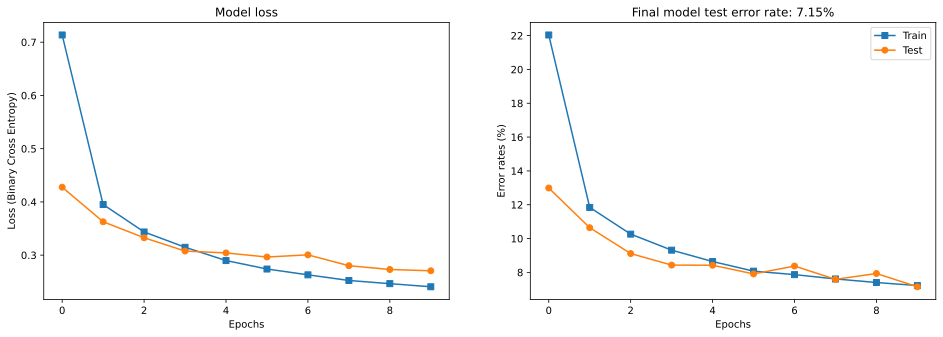

In [20]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (Cross Entropy)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

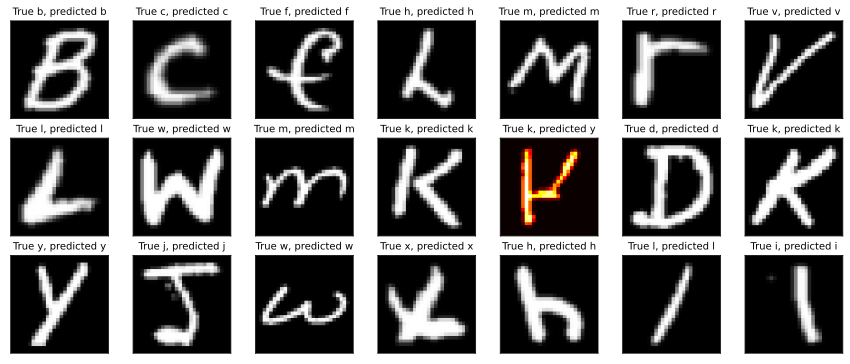

In [21]:
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
  trueLetter = letterCategories[ y[randex[i]] ]
  predLetter = letterCategories[ tr.argmax(yHat[randex[i],:]) ]

  # color-code the accuracy (using ternary operator)
  col = 'gray' if trueLetter==predLetter else 'hot'

  # visualize
  ax.imshow(I.T,cmap=col)
  ax.set_title('True %s, predicted %s' %(trueLetter,predLetter),fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

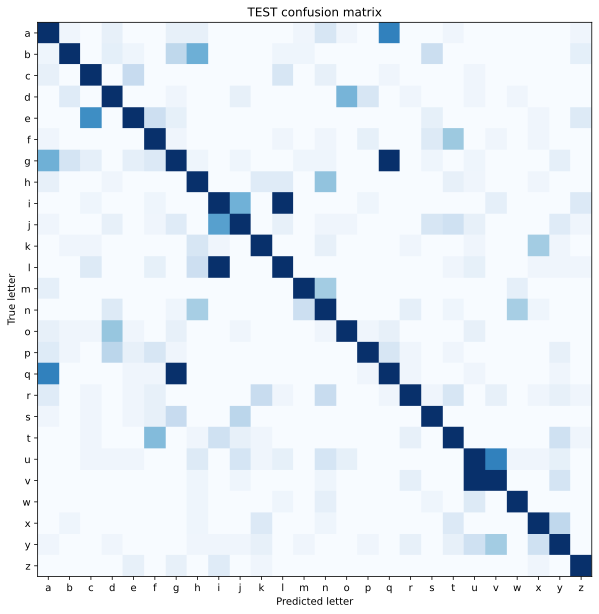

In [22]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),tr.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(26),labels=letterCategories)
plt.yticks(range(26),labels=letterCategories)
plt.title('TEST confusion matrix')
plt.xlabel('Predicted letter')
plt.ylabel('True letter')

plt.show()